In [1]:
# Setup - Run only once per Kernel App
%conda install https://anaconda.org/conda-forge/openjdk/11.0.1/download/linux-64/openjdk-11.0.1-hacce0ff_1021.tar.bz2
#%conda install https://anaconda.org/conda-forge/openjdk/11.0.1/download/osx-64/openjdk-11.0.1-hb0a8c7a_1021.tar.bz2
# install PySpark
%pip install pyspark

# install seaborn
%pip install seaborn

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")




## Package Plan ##

  environment location: /opt/conda



Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sagemaker
sess = sagemaker.Session()
bucket = sess.default_bucket()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [3]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

spark.sparkContext.setLogLevel("ERROR")
print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/sagemaker-user/.ivy2/cache
The jars for the packages stored in: /home/sagemaker-user/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-80484270-0d78-4548-81e9-2029c8aa6007;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 369ms :: artifacts dl 7ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	----------------

3.4.0


In [4]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model

In [5]:
df = spark.read.csv(f'../../../data/csv/df_ml.csv', header = True)

In [6]:
df.columns

['_c0',
 'subreddit',
 'author',
 'id',
 'text',
 'num_comments',
 'score',
 'date',
 'sentiment',
 'is_biden',
 'is_trump',
 'trump_score',
 'biden_score',
 'is_hunter',
 'is_border',
 'is_war',
 'is_israel',
 'is_harris',
 'is_indictment',
 'is_administrationt']

In [7]:
df.show()

+---+------------+-------------------+-------+--------------------+------------+-----+----------+---------+--------+--------+-----------+-----------+---------+---------+------+---------+---------+-------------+------------------+
|_c0|   subreddit|             author|     id|                text|num_comments|score|      date|sentiment|is_biden|is_trump|trump_score|biden_score|is_hunter|is_border|is_war|is_israel|is_harris|is_indictment|is_administrationt|
+---+------------+-------------------+-------+--------------------+------------+-----+----------+---------+--------+--------+-----------+-----------+---------+---------+------+---------+---------+-------------+------------------+
|  0|  Republican| interestingfactoid|1dpu59h| say her name   c...|           2|   12|2024-06-27| positive|       1|       0|        0.0|  0.8331798|        0|        1|     0|        0|        0|            0|                 0|
|  1|    politics|    Plastic-Age5205|1bqxiww|biden expands win...|           9|

<Axes: xlabel='sentiment', ylabel='count'>

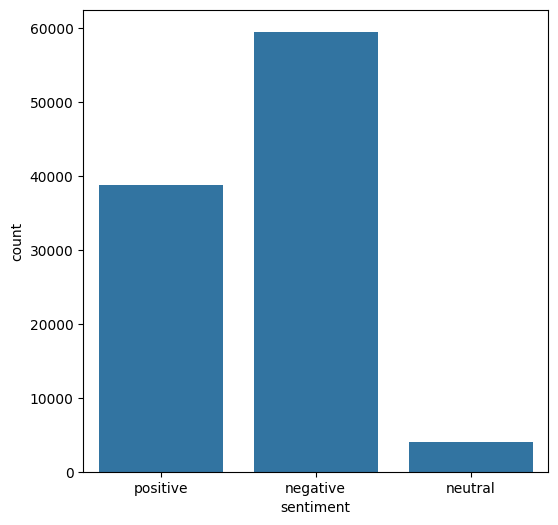

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

sns.countplot(data=df.toPandas(), x='sentiment', ax=ax)


In [9]:
df.select("subreddit").distinct().show()

+------------+
|   subreddit|
+------------+
|  Republican|
|     Liberal|
|    politics|
| Libertarian|
|   democrats|
|Conservative|
+------------+



In [10]:
from pyspark.sql.functions import concat_ws, col, year, month, regexp_replace, when, lit, udf

df = df \
    .withColumn('num_comments', col('num_comments').cast("integer")) \
    .withColumn('score', col('score').cast("integer")) \
    .withColumn('date', col('date').cast("date")) \
    .withColumn('is_biden', col('is_biden').cast("integer")) \
    .withColumn('is_trump', col('is_trump').cast("integer")) \
    .withColumn('is_hunter', col('is_hunter').cast("integer")) \
    .withColumn('is_border', col('is_border').cast("integer")) \
    .withColumn('is_war', col('is_war').cast("integer")) \
    .withColumn('is_israel', col('is_israel').cast("integer")) \
    .withColumn('is_harris', col('is_harris').cast("integer")) \
    .withColumn('is_indictment', col('is_indictment').cast("integer")) \
    .withColumn("year", year(col("date"))) \
    .withColumn("month", month(col("date"))) \
    .withColumn("clean_text", regexp_replace(col("text"), "[^a-zA-Z0-9\s]", "")) \
    .withColumn("score_label",
                when(col("score") == 0, 0)
                .when(col("score") == 1, 1)
                .when((col("score") >= 2) & (col("score") < 10), 2)
                .when((col("score") >= 10) & (col("score") < 100), 3)
                .when((col("score") >= 100) & (col("score") < 1000), 4)
                .otherwise(5)
        ) \
    .drop(*['_c0', 'id', 'date'])

In [11]:
from pyspark.sql import functions as F

political = df.withColumn(
    "party",
    F.when(
        (F.col("subreddit") == "Republican") | (F.col("subreddit") == "Conservative"),
        "Conservative"
    )
    .otherwise(
        F.when(
            (F.col("subreddit") == "Liberal") | (F.col("subreddit") == "democrats"),
            "Liberal"
        )
        .otherwise(
            F.when(
                F.col("subreddit") == "Libertarian",
                "Libertarian"
            )
            .otherwise(F.lit(None))  # Exclude by setting to None
        )
    )
)

# Filter out rows where "party" is None (those that don't match any condition)
political = political.filter(F.col("party").isNotNull())

# Show the result
political.show()

+------------+-------------------+--------------------+------------+-----+---------+--------+--------+-----------+-----------+---------+---------+------+---------+---------+-------------+------------------+----+-----+--------------------+-----------+------------+
|   subreddit|             author|                text|num_comments|score|sentiment|is_biden|is_trump|trump_score|biden_score|is_hunter|is_border|is_war|is_israel|is_harris|is_indictment|is_administrationt|year|month|          clean_text|score_label|       party|
+------------+-------------------+--------------------+------------+-----+---------+--------+--------+-----------+-----------+---------+---------+------+---------+---------+-------------+------------------+----+-----+--------------------+-----------+------------+
|  Republican| interestingfactoid| say her name   c...|           2|   12| positive|       1|       0|        0.0|  0.8331798|        0|        1|     0|        0|        0|            0|                 0|20

In [12]:
political.printSchema()

root
 |-- subreddit: string (nullable = true)
 |-- author: string (nullable = true)
 |-- text: string (nullable = true)
 |-- num_comments: integer (nullable = true)
 |-- score: integer (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- is_biden: integer (nullable = true)
 |-- is_trump: integer (nullable = true)
 |-- trump_score: string (nullable = true)
 |-- biden_score: string (nullable = true)
 |-- is_hunter: integer (nullable = true)
 |-- is_border: integer (nullable = true)
 |-- is_war: integer (nullable = true)
 |-- is_israel: integer (nullable = true)
 |-- is_harris: integer (nullable = true)
 |-- is_indictment: integer (nullable = true)
 |-- is_administrationt: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- clean_text: string (nullable = true)
 |-- score_label: integer (nullable = false)
 |-- party: string (nullable = true)



In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import pandas as pd

political_pandas = political.toPandas()

target_column = 'party'  

features = ['author', 'num_comments', 'score', 'sentiment', 
            'is_trump', 'is_harris', 'is_biden', 'is_indictment', 'is_border',
            'is_war', 'is_israel', 'is_hunter']

political_pandas['author'] = political_pandas['author'].astype('category').cat.codes
political_pandas['sentiment'] = political_pandas['sentiment'].astype('category').cat.codes

# Split the dataset into features (X) and target (y)
X = political_pandas[features]
y = political_pandas[target_column]

y = LabelEncoder().fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [15]:
forest = RandomForestClassifier(n_estimators=100)

forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

print(classification_report(y_test, y_pred))

from sklearn.preprocessing import label_binarize
import numpy as np

y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

y_prob = forest.predict_proba(X_test)


              precision    recall  f1-score   support

           0       0.88      0.92      0.90      6898
           1       0.68      0.58      0.62      1938
           2       0.21      0.15      0.18       112

    accuracy                           0.83      8948
   macro avg       0.59      0.55      0.57      8948
weighted avg       0.83      0.83      0.83      8948



In [17]:
y_prob

array([[0.94, 0.06, 0.  ],
       [1.  , 0.  , 0.  ],
       [0.76, 0.24, 0.  ],
       ...,
       [0.4 , 0.56, 0.04],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ]])

In [20]:
results_df = pd.DataFrame({
    'true_y': y_test,
    'predicted_y': y_pred,
    'probs': y_prob.tolist()
})

results_df.to_csv('../../../data/models/political_leaning_pred/results/preds.csv', index=False)

In [22]:
color_map = {
    "Republican": "red",
    "democrats": "blue",
    "Liberal": "skyblue",
    "Conservative": "pink",
    "Libertarian": "gold",
    "politics": "green",
    
}

color_list = list(color_map.values())

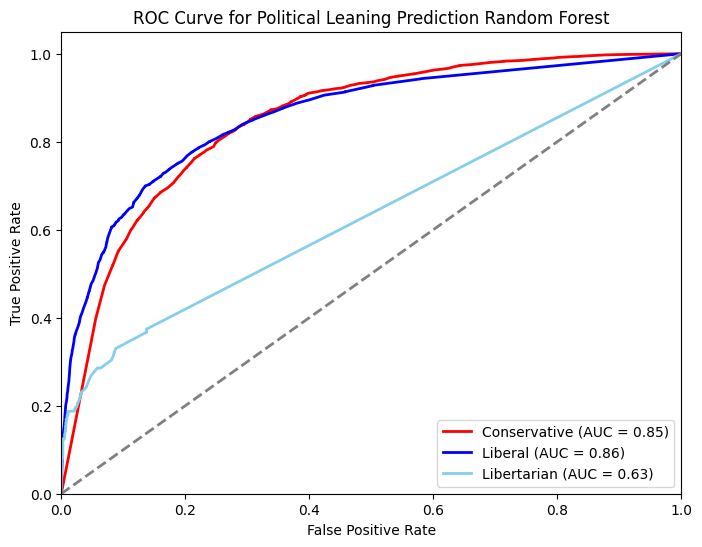

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

y_prob = forest.predict_proba(X_test)

fpr, tpr, roc_auc = {}, {}, {}
class_names = ['Conservative','Liberal','Libertarian']
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})', color=color_list[i])
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Political Leaning Prediction Random Forest')
plt.legend(loc='lower right')
plt.savefig('political_leaning_roc.png', format='png', dpi=300, bbox_inches='tight')  
plt.show()


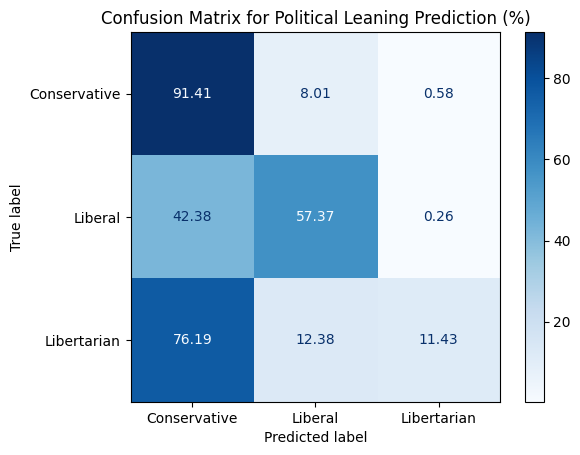

In [16]:
conf_matrix = confusion_matrix(y_test, y_pred)

conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percent, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")

plt.title('Confusion Matrix for Political Leaning Prediction (%)')
plt.savefig('political_leaning_confusion_matrix.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
from pyspark.ml.feature import HashingTF, Tokenizer, IDF, Normalizer, StandardScaler, OneHotEncoder, StringIndexer, VectorAssembler, MinMaxScaler, Word2Vec
from pyspark.ml import Pipeline

#tokenizer = Tokenizer(inputCol="text", outputCol="words")
#hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="rawFeatures", numFeatures=500)
#idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="tfidf")

author_indexer = StringIndexer(inputCol="author", outputCol="author_index")

sentiment_indexer = StringIndexer(inputCol="sentiment", outputCol="sentiment_index")
party_indexer = StringIndexer(inputCol='party', outputCol='indexed_party')

sentiment_encoder = OneHotEncoder(inputCol="sentiment_index", outputCol="sentiment_vector")

# Normalize all input features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Assemble all features into a single vector
assembler = VectorAssembler(
    inputCols=[
        "num_comments", "score",
        "sentiment_vector", "is_biden", "is_trump", "is_hunter", 
        "is_border", "is_war", "is_israel", "is_harris",
        "is_indictment"
    ],
    outputCol="features",
)

# Build the pipeline
pipeline = Pipeline(
    stages=[
        author_indexer,
        sentiment_indexer,
        party_indexer,
        sentiment_encoder,
        assembler,
        scaler
    ]
)

In [25]:
pipeline_model = pipeline.fit(political)


In [26]:
modeling_df = pipeline_model.transform(political)


In [27]:
(train, test) = modeling_df.randomSplit([0.8, 0.2], seed=1989)

evaluator = MulticlassClassificationEvaluator(labelCol="indexed_party", predictionCol="prediction", metricName="accuracy")


In [38]:
from pyspark.sql.functions import lit

most_common_class = train.groupBy('indexed_party').count().orderBy('count', ascending=False).first()['indexed_party']
most_common_class

predictions = test.withColumn('prediction', lit(most_common_class))
acc = evaluator.evaluate(predictions)

print(f"Most common class accuracy (baseline model): {acc:.2%}")

Most common class accuracy (baseline model): 77.09%


In [39]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model

In [ ]:
rf = RandomForestClassifier(labelCol="indexed_party", featuresCol="scaled_features")

rf_model = rf.fit(train)
rf_preds = rf_model.transform(test)
rf_acc = evaluator.evaluate(rf_preds)

print(f"Random Forest Model Accuracy: {rf_acc:.2%}")

In [26]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

rf = RandomForestClassifier(labelCol="indexed_party", featuresCol="scaled_features")

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30, 40]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

crossval = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3
)

cvModel = crossval.fit(train)

best_model = cvModel.bestModel

# Save model with overwrite
best_model.write().overwrite().save("best_rf_model")

predictions = best_model.transform(test)
rf_best_acc = evaluator.evaluate(predictions)
print(f"Best Random Forest model accuracy: {rf_best_acc:.2%}")

Best Random Forest model accuracy: 78.20%


    accuracy  numTrees  maxDepth
0   0.773023      10.0       5.0
1   0.785353      10.0      10.0
2   0.785853      10.0      15.0
3   0.774612      20.0       5.0
4   0.785659      20.0      10.0
5   0.787225      20.0      15.0
6   0.772685      30.0       5.0
7   0.786615      30.0      10.0
8   0.787733      30.0      15.0
9   0.773077      40.0       5.0
10  0.785773      40.0      10.0
11  0.788237      40.0      15.0


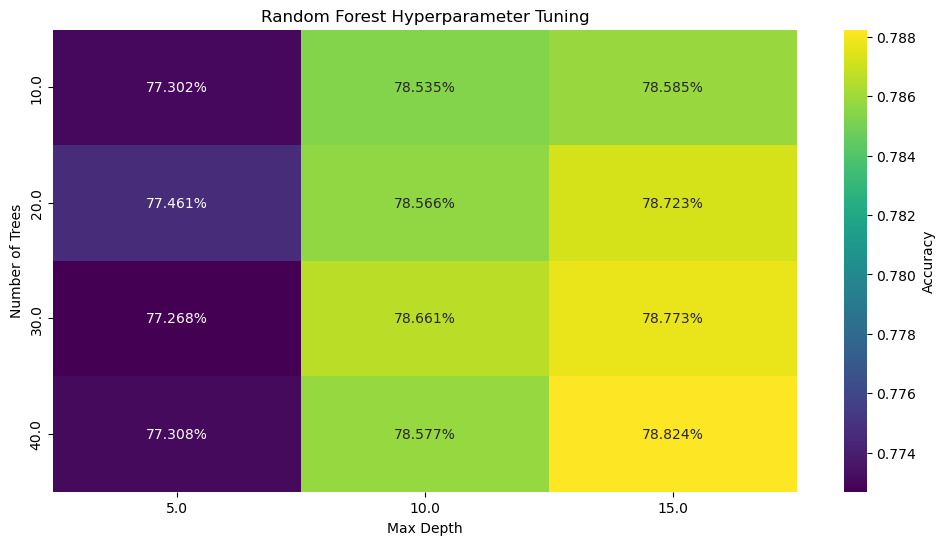

In [27]:
import seaborn as sns
import pandas as pd

cv_results = pd.DataFrame(cvModel.avgMetrics, columns=["accuracy"])
# Extract hyperparameters
paramGrid = cvModel.getEstimatorParamMaps()

for i, params in enumerate(paramGrid):
    for key, value in params.items():
        cv_results.loc[i, key.name] = value

cv_results.to_csv("rf_cv_results.csv")
print(cv_results)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

heatmap_data = cv_results.pivot(index="numTrees", columns="maxDepth", values="accuracy")

sns.heatmap(data=heatmap_data, annot=True, ax=ax, cmap="viridis", fmt=".3%")

plt.title("Random Forest Hyperparameter Tuning")

ax.set_xlabel("Max Depth")
ax.set_ylabel("Number of Trees")

ax.collections[0].colorbar.set_label("Accuracy")

plt.show()

In [ ]:
dt = DecisionTreeClassifier(labelCol="indexed_party", featuresCol="scaled_features")

dt_model = dt.fit(train)
dt_preds = dt_model.transform(test)
dt_acc = evaluator.evaluate(dt_preds)

print(f"Decision Tree Model Accuracy: {dt_acc:.2%}")

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

dt = DecisionTreeClassifier(labelCol="indexed_party", featuresCol="scaled_features")

paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [10, 20, 30]) \
    .build()

crossval = CrossValidator(
    estimator=dt,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5
)

cvModel = crossval.fit(train)

best_model = cvModel.bestModel

# Save model with overwrite
best_model.write().overwrite().save("best_dt_model")

In [43]:
best_model = RandomForestClassifier(labelCol="indexed_party", featuresCol="scaled_features", numTrees=40, maxDepth=15)

best_model = best_model.fit(train)

In [44]:
dt_best_preds = best_model.transform(test)
dt_best_acc = evaluator.evaluate(dt_best_preds)
print(f"Best Decision Tree model accuracy: {dt_best_acc:.2%}")

Best Decision Tree model accuracy: 78.71%


In [ ]:
# Load the best model
best_model = Model.load("best_dt_model")

In [ ]:
cv_results = pd.DataFrame(cvModel.avgMetrics, columns=["accuracy"])
paramGrid = cvModel.getEstimatorParamMaps()
for i, params in enumerate(paramGrid):
    for key, value in params.items():
        cv_results.loc[i, key.name] = value

cv_results.to_csv("dt_cv_results.csv")
print(cv_results)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
heatmap_data = cv_results.pivot(index="maxDepth", columns="maxBins", values="accuracy")

sns.heatmap(data=heatmap_data, annot=True, ax=ax, cmap="viridis", fmt=".3%")
plt.title("Decision Tree Hyperparameter Tuning")
ax.set_xlabel("Max Bins")
ax.set_ylabel("Max Depth")
ax.collections[0].colorbar.set_label("Accuracy")

plt.show()

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract feature importances from the best model
feature_importances = best_model.featureImportances.toArray()

# Get feature names from the VectorAssembler stage in the pipeline
# In your pipeline, the assembler is the 4th stage
assembler_stage = pipeline_model.stages[4]
feature_names = assembler_stage.getInputCols()

# Combine feature names and importances into a dictionary
feature_importances_dict = dict(zip(feature_names, feature_importances))

# Sort the dictionary by importance (descending order)
sorted_features = sorted(feature_importances_dict.items(), key=lambda x: x[1], reverse=True)


In [48]:
sorted_feature_names = [item[0] for item in sorted_features]
sorted_importances = [item[1] for item in sorted_features]
clean_names = [
    'Score', 'Number of Comments', 'Mentions Hunter Biden',
    'Mentions border', 'Mentions indictment', 'Mentions Trump',
    'Sentiment', 'Mentions Biden', 'Mentions war', 'Mentions Israel',
    'Mentions Harris'
]


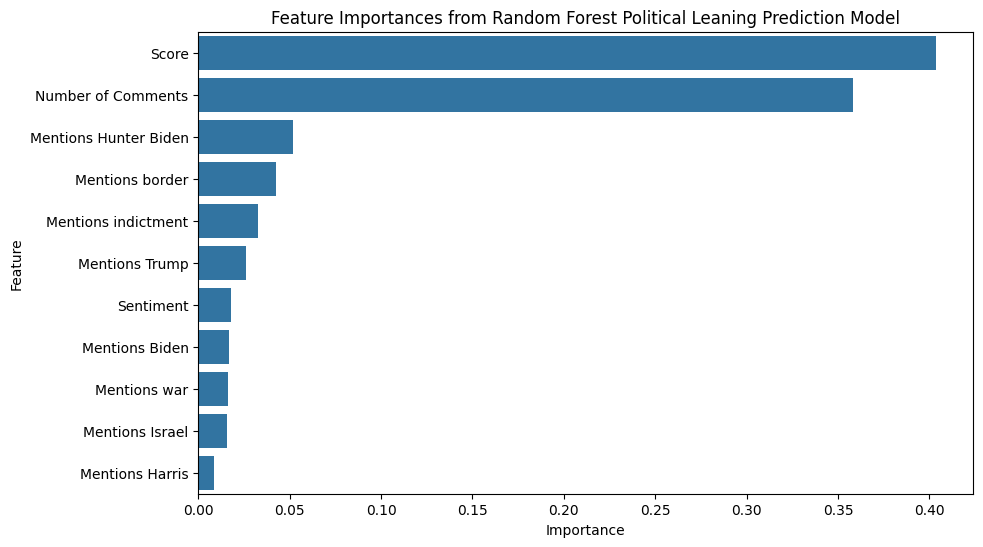

In [50]:
# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importances, y=clean_names)

# Customize the plot
plt.title("Feature Importances from Random Forest Political Leaning Prediction Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.savefig("feature_importances_rf.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
import pandas as pd
results = pd.read_csv("../../../data/models/political_leaning_pred/results/preds.csv")

In [8]:
from sklearn.metrics import classification_report
report = classification_report(results['true_y'], results['predicted_y'], output_dict=True)

overall_metrics = pd.DataFrame(index=["accuracy", "precision", "recall", "f1-score", "support"],columns=["value"])
overall_metrics.loc["accuracy"] = report["accuracy"]
overall_metrics.loc["precision"] = report["macro avg"]["precision"]
overall_metrics.loc["recall"] = report["macro avg"]["recall"]
overall_metrics.loc["f1-score"] = report["macro avg"]["f1-score"]
overall_metrics.loc["support"] = report["macro avg"]["support"]

print(overall_metrics)

overall_metrics.to_csv("../../../data/models/political_leaning_pred/results/overall_metrics.csv")

              value
accuracy    0.83203
precision  0.582715
recall     0.540143
f1-score   0.557256
support      8948.0
